In [1]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
 
parent_folder = "./ml_exercise_therapanacea"

# original image folder and data labels documents
original_folder = os.path.join(parent_folder, "train_img")
labels_file = os.path.join(parent_folder, "label_train.txt")

# Read labels into a list
with open(labels_file, "r") as f:
    labels = [int(line.strip()) for line in f]
label_counts = Counter(labels)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


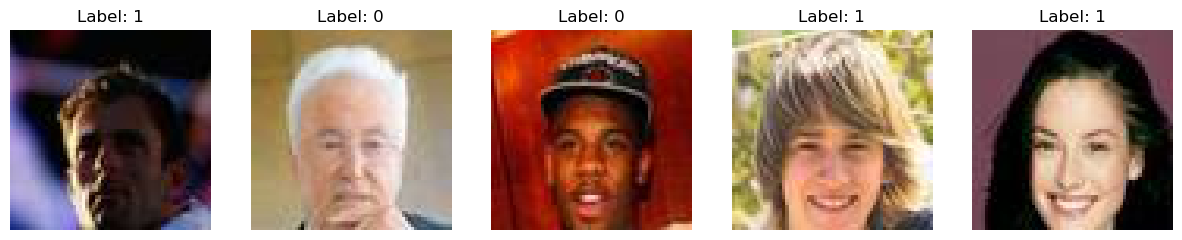

In [2]:
image_files = [f"{i+1:06d}.jpg" for i in range(len(labels))]
k = 956
sample_images = image_files[k:k+5]

plt.figure(figsize=(15, 10))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(original_folder, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Label: {labels[i+k]}")
    plt.axis('off')

plt.show()


### Visual analysis
Visually, it is challenging to discern the relationship between the labels and the images, yet.



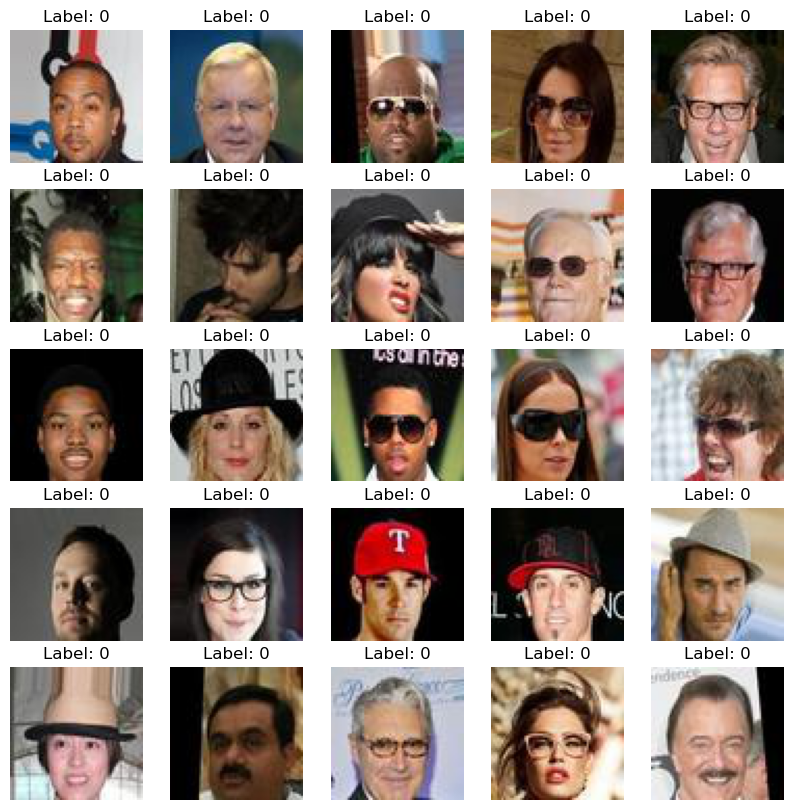

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define the paths
original_folder = os.path.join(parent_folder, "train_img")
labels_file = os.path.join(parent_folder, "label_train.txt")

# Read labels into a list
with open(labels_file, "r") as f:
    labels = [int(line.strip()) for line in f]

# Get the indices of images with label 0
indices_with_label_0 = [i for i, label in enumerate(labels) if label == 0]
e = 28
# Plot the first 25 images with label 0
plt.figure(figsize=(10, 10))
for i in range(e, e+25):
    img_path = os.path.join(original_folder, f"{indices_with_label_0[i]+1:06d}.jpg")
    img = Image.open(img_path)
    plt.subplot(5, 5, i + 1-e)
    plt.imshow(img)
    plt.title(f"Label: 0")
    plt.axis('off')

plt.show()

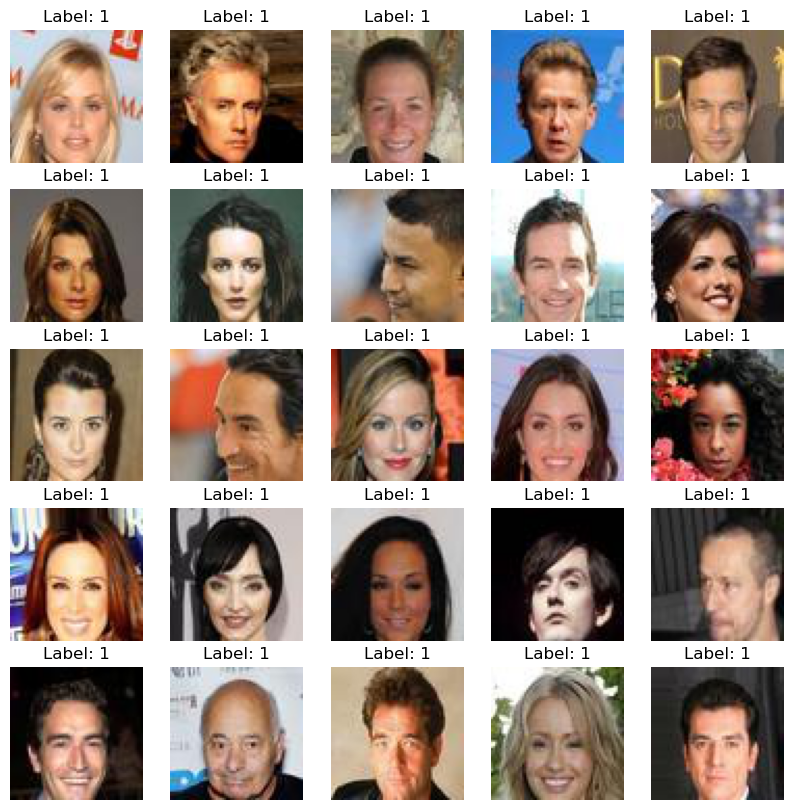

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define the paths
original_folder = os.path.join(parent_folder, "train_img")
labels_file = os.path.join(parent_folder, "label_train.txt")

# Read labels into a list
with open(labels_file, "r") as f:
    labels = [int(line.strip()) for line in f]

# Get the indices of images with label 1
indices_with_label_1 = [i for i, label in enumerate(labels) if label == 1]

# Plot the first 25 images with label 1
plt.figure(figsize=(10, 10))
for i in range(e, e+ 25):
    img_path = os.path.join(original_folder, f"{indices_with_label_1[i]+1:06d}.jpg")
    img = Image.open(img_path)
    plt.subplot(5, 5, i + 1-e)
    plt.imshow(img)
    plt.title(f"Label: 1")
    plt.axis('off')

plt.show()

#### Interpretation of Labels in Facial Data

It appears that the labels in this dataset might be distinguishing between two categories:

1. **Unobstructed Faces:** Faces without any obstructions, where the head is clearly visible.
2. **Obstructed Faces:** Faces with some form of obstruction, such as wearing hats or glasses, or when hands are partially covering the face.

In [5]:
label_counts = Counter(labels)
print(f"labels counter: {label_counts}")

labels counter: Counter({1: 87898, 0: 12102})


#### Dataset Imbalance
We are working with a binary dataset that is highly imbalanced, with the positive labels being seven times more frequent than the negative labels.

To properly evaluate the model, we will split the dataset into training and testing sets, ensuring that the test set is balanced (see `split_dataset` module). Additionally, during training, we will apply weighted sampling to account for the imbalance in the dataset.

In [6]:
# run this cell to split the original dataset into train/test dataset as described above.
#!python split_dataset.py

The folder structure is now this one   


In [7]:
#| dataset  
#|   |---- train 
#|           |---- 0
#|              |---- 0*****.jpg
#|              |---- 0*****.jpg
#|           |---- 1
#|              |---- 0*****.jpg
#|              |---- 0*****.jpg
#|   |---- test 
#|           |---- 0
#|              |---- 0*****.jpg
#|              |---- 0*****.jpg
#|           |---- 1
#|              |---- 0*****.jpg
#|              |---- 0*****.jpg

#### Dataloader
 We will use a dataset loader to load the dataset. During the training we will sample from the dataset while taking in account the imbalanceness if the data, we can also also augment the data by mirroring and rotating within a fixed range the images. Further more we can also apply some blurring. In here we will just resize to 224 and mirror.

#### Model
We will use a state-of-the-art classifier model: ViT (Vision Transformer), a transformer-based architecture. We will initialize its weights using the publicly available pre-trained weights from Hugging Face and fine-tune the model using our training dataset.

The images will be resized to 224x224 to match the dimensions used in the original ViT training dataset.

In [8]:
#!train_model.py

In [9]:
!python best_model.py

Best model overall by accuracy: Step 215 with accuracy 0.903
Best model overall by F1-score: Step 215 with F1-score 0.9078822412155746
Best saved model by accuracy (every 25 steps): Step 800 with accuracy 0.885
Best saved model by F1-score (every 25 steps): Step 800 with F1-score 0.8938134810710988


In [10]:
import re
import matplotlib.pyplot as plt

# Function to parse the log file and extract metrics for all steps and saved steps
def extract_metrics(file_path):
    # Dictionaries to store metrics
    steps_loss = []
    losses = []
    
    steps_metrics = []
    accuracies = []
    f1_scores = []
    
    saved_steps = []
    saved_accuracies = []
    saved_f1_scores = []
    saved_losses = []

    # Regex patterns to match evaluation metrics and loss
    pattern_metrics = r"eval_accuracy: ([\d\.]+), eval_loss: ([\d\.]+), eval_precision: [\d\.]+, eval_recall: [\d\.]+, eval_f1: ([\d\.]+), eval_runtime: [\d\.]+, eval_samples_per_second: [\d\.]+, eval_steps_per_second: [\d\.]+, epoch: [\d\.]+, step: (\d+)"
    pattern_loss = r"loss: ([\d\.]+), grad_norm: [\d\.]+, learning_rate: [\d\.]+, epoch: [\d\.]+, step: (\d+)"

    # Open and read the log file line by line
    with open(file_path, 'r') as file:
        for line in file:
            match_metrics = re.search(pattern_metrics, line)
            match_loss = re.search(pattern_loss, line)
            
            if match_metrics:
                step = int(match_metrics.group(4))
                steps_metrics.append(step)
                accuracies.append(float(match_metrics.group(1)))
                f1_scores.append(float(match_metrics.group(3)))

                if step % 25 == 0:
                    saved_steps.append(step)
                    saved_accuracies.append(float(match_metrics.group(1)))
                    saved_f1_scores.append(float(match_metrics.group(3)))

            if match_loss:
                step = int(match_loss.group(2))
                steps_loss.append(step)
                losses.append(float(match_loss.group(1)))

                # Match saved steps with available loss values
                if step % 25 == 0 and step in saved_steps:
                    saved_losses.append(float(match_loss.group(1)))

    return steps_loss, losses, steps_metrics, accuracies, f1_scores, saved_steps, saved_accuracies, saved_f1_scores, saved_losses

# Function to plot the metrics
def plot_metrics(file_path):
    # Extract metrics from the log file
    steps_loss, losses, steps_metrics, accuracies, f1_scores, saved_steps, saved_accuracies, saved_f1_scores, saved_losses = extract_metrics(file_path)

    # Create subplots
    plt.figure(figsize=(15, 5))

    # Plot loss over steps
    plt.subplot(1, 3, 1)
    plt.plot(steps_loss, losses, label='Loss (All Steps)', color='purple', marker='o')
    if len(saved_losses) > 0:  # Only plot if saved_losses is not empty
        plt.plot(saved_steps[:len(saved_losses)], saved_losses, label='Loss (Saved Steps)', color='brown', marker='x')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Loss Over Steps')
    plt.legend()

    # Plot accuracy over steps
    plt.subplot(1, 3, 2)
    plt.plot(steps_metrics, accuracies, label='Accuracy (Every 5 Steps)', color='blue', marker='o')
    plt.plot(saved_steps, saved_accuracies, label='Accuracy (Saved Steps)', color='red', marker='x')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Steps')
    plt.legend()

    # Plot F1-score over steps
    plt.subplot(1, 3, 3)
    plt.plot(steps_metrics, f1_scores, label='F1-score (Every 5 Steps)', color='green', marker='o')
    plt.plot(saved_steps, saved_f1_scores, label='F1-score (Saved Steps)', color='orange', marker='x')
    plt.xlabel('Step')
    plt.ylabel('F1-score')
    plt.title('F1-score Over Steps')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

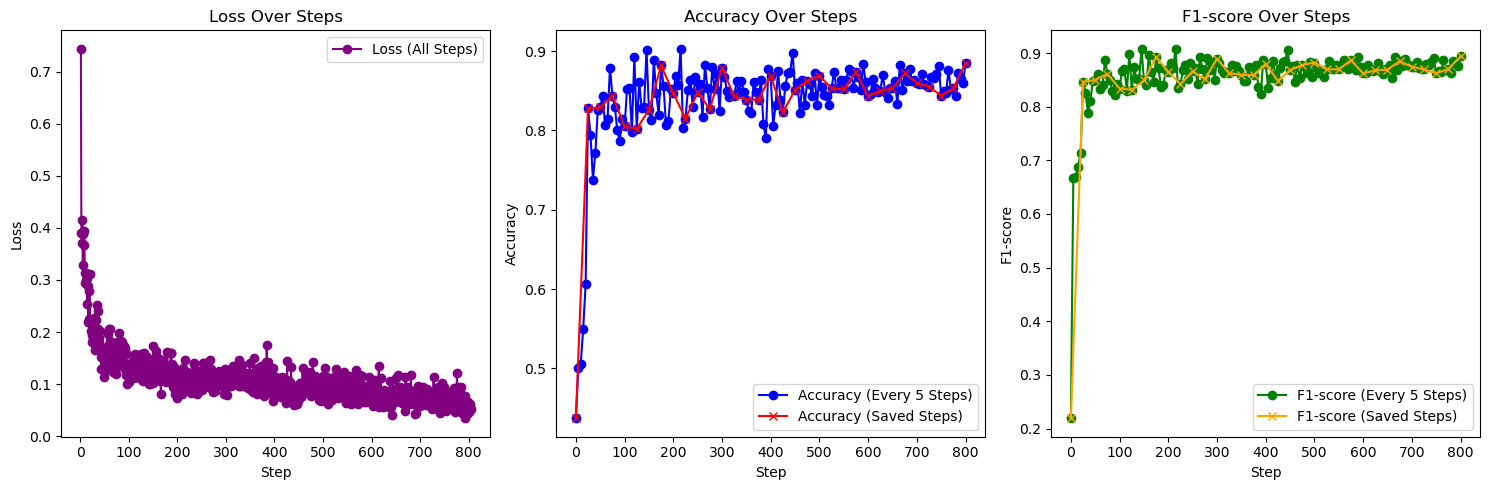

In [11]:

    
# File path to the log file
log_file_path = './output_logs.txt'

# Call the function to plot the metrics
plot_metrics(log_file_path)

In [12]:
# Load the best model saved (175th step) and infer the validation dataset

#! python infer.py